In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from store import *

In [2]:
store = Store(os.getenv('localappdata') + r'\Kaspad\kaspa-mainnet\datadir2')
store.load_blocks()

Pruning point:  d377399dfb9b4d21389228bff2c7abfbaeb1069867ecf53b3bbf292b373496f6
Loaded 40000 blocks
Loaded 80000 blocks
Loaded 120000 blocks
Loaded 160000 blocks
Loaded 200000 blocks
Loaded 240000 blocks
Loaded 280000 blocks
Overall number of headers:  308857


In [3]:
header_fields = ['timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty']
block_fields = ['pubkey_script']
count_fields = ['num_parents', 'num_children', 'num_blues', 'num_reds']
frames = store.load_data(header_fields=header_fields, block_fields=block_fields, count_fields=count_fields)

Loaded data of 10000 blocks
Loaded data of 20000 blocks
Loaded data of 30000 blocks
Loaded data of 40000 blocks
Loaded data of 50000 blocks
Loaded data of 60000 blocks
Loaded data of 70000 blocks
Loaded data of 80000 blocks
Loaded data of 90000 blocks
Loaded data of 100000 blocks
Loaded data of 110000 blocks
Loaded data of 120000 blocks
Loaded data of 130000 blocks
Loaded data of 140000 blocks
Loaded data of 150000 blocks
Loaded data of 160000 blocks
Loaded data of 170000 blocks
Loaded data of 180000 blocks
Loaded data of 190000 blocks
Loaded data of 200000 blocks
Loaded data of 210000 blocks
Loaded data of 220000 blocks
Loaded data of 230000 blocks
Loaded data of 240000 blocks
Loaded data of 250000 blocks
Loaded data of 260000 blocks
Loaded data of 270000 blocks
Loaded data of 280000 blocks
Loaded data of 290000 blocks
Loaded data of 300000 blocks
Number of headers missing header data:  1
Number of blocks missing block data:  1


In [4]:
frames.keys()

dict_keys(['hash', 'timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty', 'pubkey_script', 'num_parents', 'num_children', 'num_blues', 'num_reds'])

In [5]:
df = pd.DataFrame(frames).set_index('hash')

In [6]:
pp_time = store.get_header_data(store.pruning_point()).timeInMilliseconds
pp_time

1642422266026

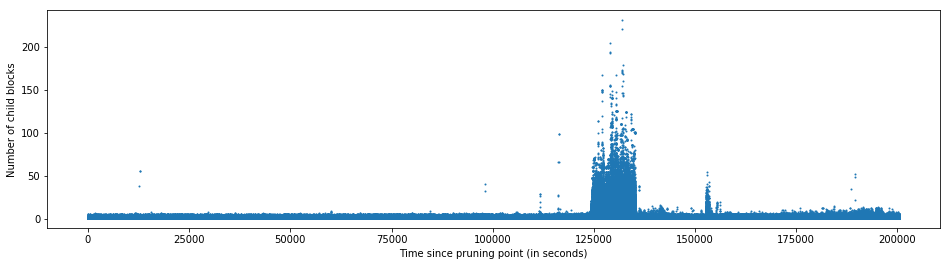

In [7]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_children'], s=1)
plt.ylabel('Number of child blocks')
plt.xlabel('Time since pruning point (in seconds)')
plt.show()

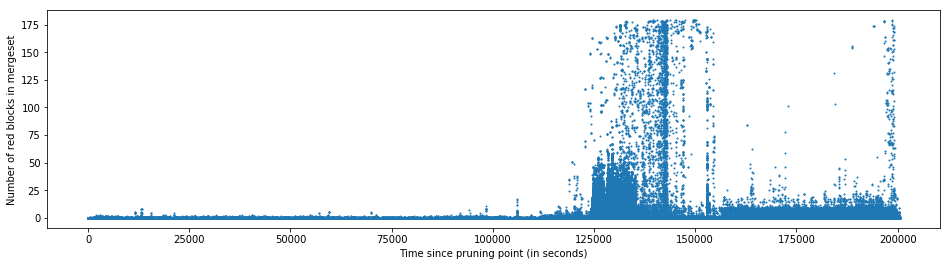

In [8]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_reds'], s=1)
plt.ylabel('Number of red blocks in mergeset')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'reds.png')
plt.show()

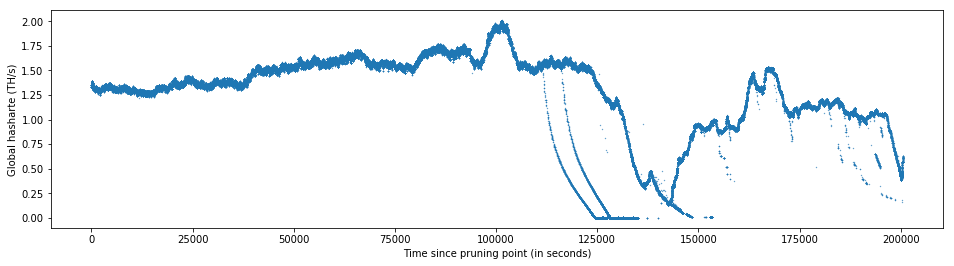

In [9]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['difficulty']*2/1000000000000, s=0.1)
plt.ylabel('Global hasharte (TH/s)')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'ghr.png')
plt.show()

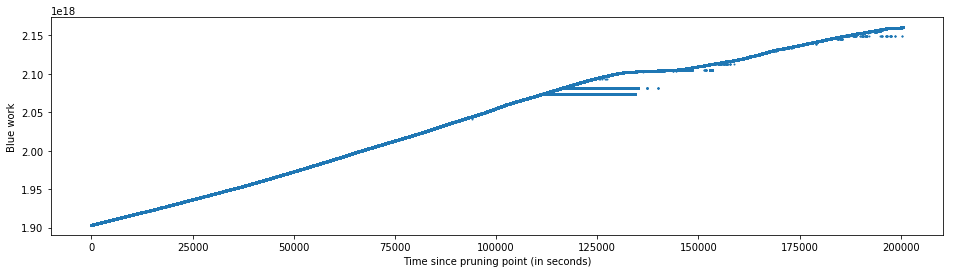

In [10]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueWork'], s=1)
plt.ylabel('Blue work')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'bw.png')
plt.show()

In [12]:
df_sortedby_time = df.sort_values(by='timeInMilliseconds')

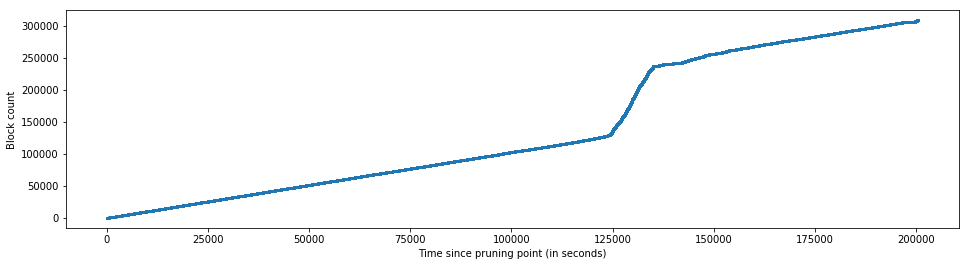

In [13]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, np.arange(len(df_sortedby_time['daaScore'])), s=1)
plt.ylabel('Block count')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'count.png')
plt.show()

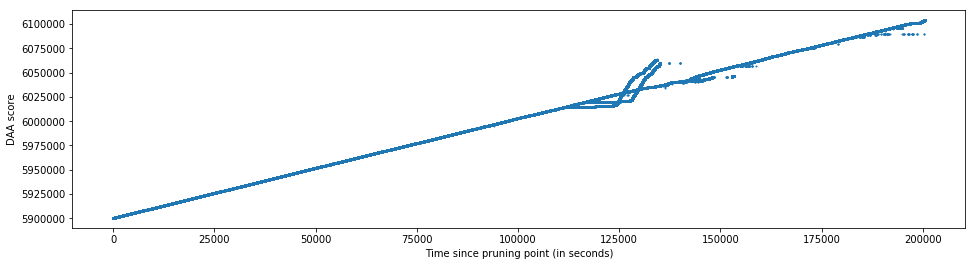

In [14]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, df_sortedby_time['daaScore'], s=1)
plt.ylabel('DAA score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'daa.png')
plt.show()

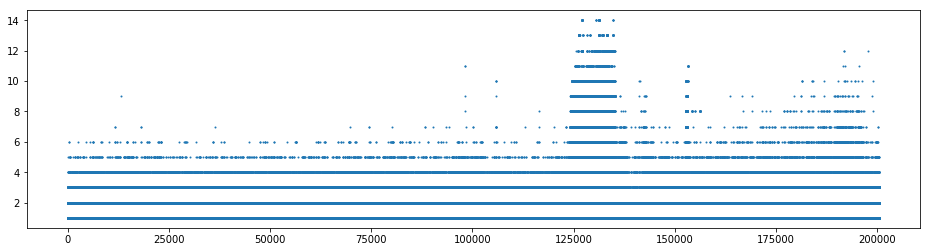

In [15]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_blues'], s=1)
plt.show()

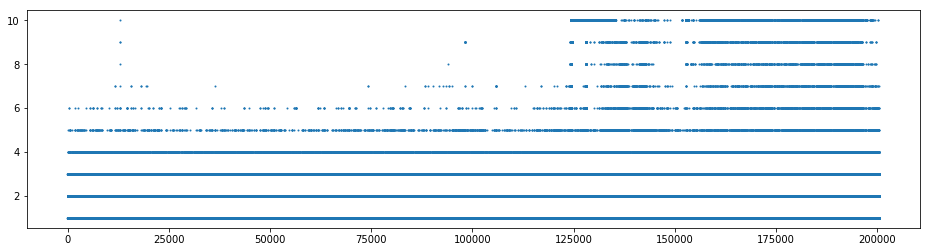

In [16]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_parents'], s=1)
plt.show()

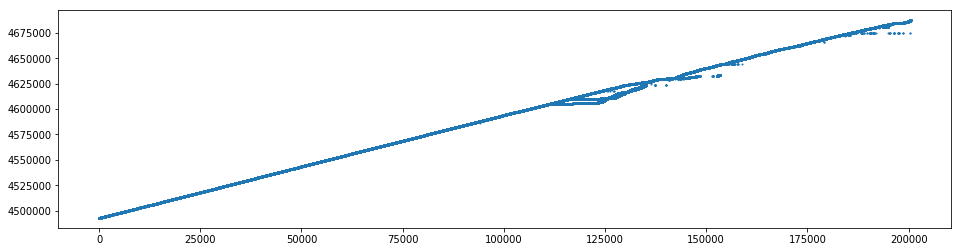

In [17]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueScore'], s=1)
plt.show()

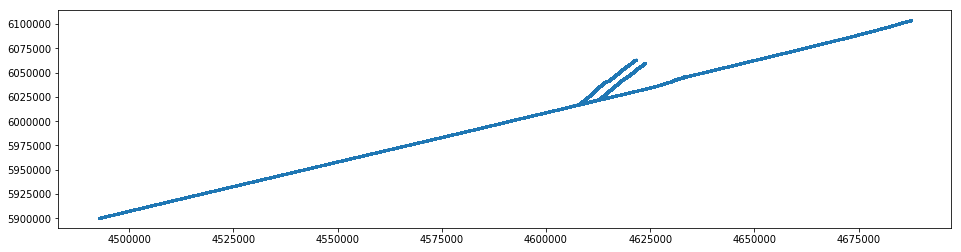

In [18]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueScore'], df['daaScore'], s=1)
plt.show()

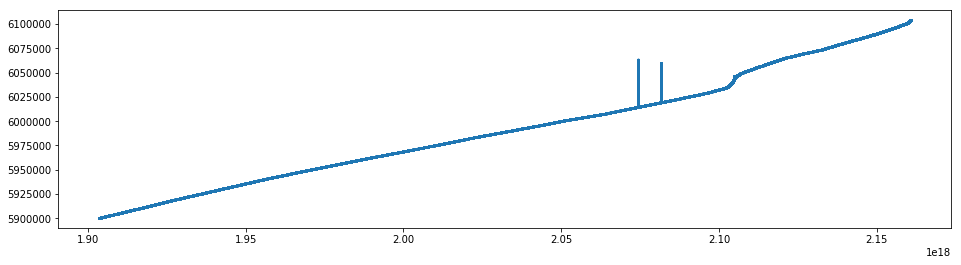

In [19]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueWork'], df['daaScore'], s=1)
plt.show()

In [20]:
df_groupedby_miner = df.groupby('pubkey_script')

In [35]:
len(df_groupedby_miner)

578

In [33]:
# Goal: explore mining addresses of red blocks 

virtual_reds = store.get_virtual_reds(threshold=0, time_distance=3600)
len(virtual_reds)

113229

In [36]:
miner_scripts = {}
for r in virtual_reds:
    if r in df.index:
        key = df.loc[r]['pubkey_script']
        if key in miner_scripts:
            miner_scripts[key] += 1
        else:
            miner_scripts[key] = 1
len(miner_scripts)

426

In [39]:
miners_sortedby_reds = sorted(miner_scripts.items(), key=lambda kvp: kvp[1], reverse=True)

***Miner public -key scripts with large amounts of red blocks:***

In [42]:
for kvp in miners_sortedby_reds:
    if kvp[1] < 500:
        break
    print(kvp[0].hex(), '\t', kvp[1])

aa20af7f68183a9c26f1901b4a6bd44dc94170bcd838ffe0715b67d59aab8c6817ea87 	 23310
20b313ab26bf182939e295e9715cda8331b3d87d70312bfbf71fb6b7d0927a5000ac 	 19548
20efbb5e841753f18a78329f73818c0dab0b206201c84df52b30eb388dc9f8975fac 	 15410
20993d2795bb0ad8d0ef7fcfb736a229da8ac941336b3ebefcbce44749bbe5d44bac 	 15079
2038e676cdf23f8865743dc051a96a72dfb63f60cd6fcaf4a66801cd928e629c99ac 	 9924
20901438e65f87c752b10c051190e0c6672a8f9edc0e82516b049015d1bf453b3fac 	 5716
20f7c7f2c388f7e98332143df363bf33db799d05472dfb497964bb8c0141da8574ac 	 5556
20b96eaf506c4f0a3c9e243e4dfb4a337356e1bc40908abed4e3cc7ffb536e5da4ac 	 3872
2064156a28f0d5c83f6fca68f8e80fdf431db45240e093acfb3ae1c63608e3000fac 	 2511
20030f3ce8a5ed0b8872041b5feaf3801dcdbe277bff55acc2a4c16b12e866adc9ac 	 691
205008a78c168be7fbed9501dca33a2d53d08d8bf03e7413831b0bbc8bb395f23dac 	 661
20bc9d30ce088fd4fbabc2a7d8aaec9feaa597cddfe24c7804141f3a763a4d9703ac 	 654
207757618a74b8ce77a6486db6604bd67ea8dc41938c3e29c9a540f2c0e72549a1ac 	 574


In [ ]:
# store.close()